In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

ImportX = pd.read_csv("gp_x.csv", header=None)
ImportT = pd.read_csv("gp_t.csv", header=None)

training_input = ImportX.iloc[:50].values
test_input = ImportX.iloc[50:].values
training_target = ImportT.iloc[:50].values
test_target = ImportT.iloc[50:].values

# 1 Gaussian Process for Regression

In [ ]:
LenTrain = len(training_input)

thetas = [[0, 0, 0, 1],
      [1, 16, 0, 0],
      [1, 16, 0, 4],
      [1, 64, 32, 0]]
beta_inv = 1
x_axis = np.linspace(0, 1, 50)

In [ ]:
def kernel(xn, xm, theta):
  return theta[0] * np.exp((theta[1]/-2)*(xn - xm)**2) + theta[2] + theta[3]*(xn*xm)

def Covariance(training_input, theta):
  xn = np.concatenate((training_input, training_input), axis=1)
  xm = np.concatenate((training_input.T, training_input.T), axis=0)
  for i in range(LenTrain-2):
    xn = np.concatenate((xn, training_input), axis=1)
    xm = np.concatenate((xm, training_input.T), axis=0)
  
  k = kernel(xn, xm, theta)
  CN = k + beta_inv * np.eye(LenTrain)
  return CN

def predictive_distrbution(training_input, training_target, x_axis, CN, beta_inv, theta):
  CN_inv = np.linalg.inv(CN)
  X_axis = len(x_axis)
  mean = np.empty(X_axis)
  std = np.empty(X_axis)

  for i in range(X_axis):
    k = kernel(training_input, x_axis[i], theta)
    mean[i] = np.linalg.multi_dot([k.T, CN_inv, training_target])
    c = kernel(x_axis[i], x_axis[i], theta) + 1
    std[i] = np.sqrt(c - np.linalg.multi_dot([k.T, CN_inv, k]))
  return mean, std

def Gaussian_Process(training_input, training_target, x_axis, beta_inv, theta):
  CN = Covariance(training_input, theta)
  mean , std = predictive_distrbution(training_input, training_target, x_axis, CN, beta_inv, theta)
  return mean, std

def plot(x_axis, mean, std, training_input, training_target, theta):
  plt.title('Gaussian Process Example\n' r'$\theta$ = [%.1f, %.1f, %.1f, %.1f]' % (theta[0], theta[1], theta[2], theta[3]))
  plt.plot(x_axis, mean, label='Mean', color='red')
  plt.fill_between(x_axis, mean+std, mean-std, color='pink', alpha=0.6)
  plt.xlabel('x')
  plt.ylabel('t')
  plt.scatter(training_input, training_target, marker='o', c='', edgecolors='b')
  plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.3)
  plt.show()

def RMSE(mean_xn, tn):
  rmse = 0
  for i in range(50):
    rmse += (mean_xn[i]-tn[i])**2
  # RMSE = np.mean(rmse)
  return np.sqrt(rmse / 50)
  # return np.sqrt(((mean_xn-tn)**2)/50)

Plot the prediction result.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


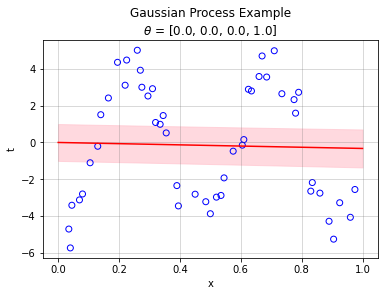

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


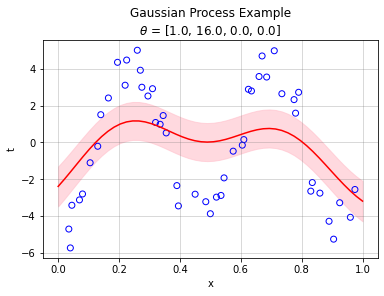

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


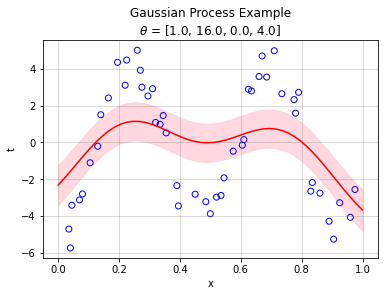

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


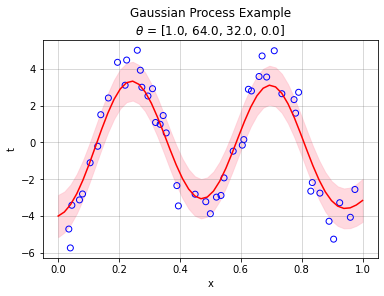

In [ ]:
for i in range(4):
  mean, std = Gaussian_Process(training_input, training_target, x_axis, beta_inv, thetas[i])
  plot(x_axis, mean, std, training_input, training_target, thetas[i])


Show the corresponding root-mean-square errors for both training and test sets with respect to the four kernels.

In [ ]:
training_RMSE = []
test_RMSE = []

for i in range(4):
  mean, std = Gaussian_Process(training_input, training_target, training_input, beta_inv, thetas[i])
  train_rmse = RMSE(mean, training_target)
  training_RMSE.append(train_rmse)
  mean, std = Gaussian_Process(test_input, test_target, test_input, beta_inv, thetas[i])
  test_rmse = RMSE(mean, test_target)
  test_RMSE.append(test_rmse)

print(tabulate([[thetas[0], training_RMSE[0], test_RMSE[0]], [thetas[1], training_RMSE[1], test_RMSE[1]], [thetas[2], training_RMSE[2], test_RMSE[2]], [thetas[3], training_RMSE[3], test_RMSE[3]]], headers=['Theta', 'Training RMSE', 'Test RMSE'], tablefmt='psql', stralign='center', numalign='center'))

+----------------+-----------------+-------------+
|     Theta      |  Training RMSE  |  Test RMSE  |
|----------------+-----------------+-------------|
|  [0, 0, 0, 1]  |     3.1292      |   3.32018   |
| [1, 16, 0, 0]  |     2.42393     |   2.46569   |
| [1, 16, 0, 4]  |     2.41058     |   2.45577   |
| [1, 64, 32, 0] |     1.04289     |   1.09253   |
+----------------+-----------------+-------------+


Automatic Relevance Determination (ARD)

ARD_theta =  [28.61716136 28.45223937 24.46730624  1.26537751]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


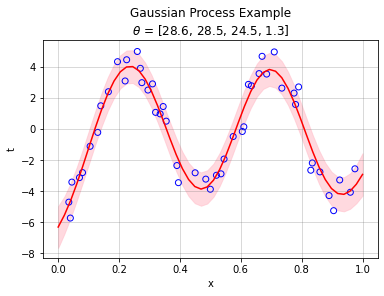

ARD RMSE =  [0.7733451]


In [ ]:
ARD_theta = np.zeros(4)
ARD_delta = np.empty(4)
Ptheta = np.zeros(4)
i = 0

lr = 0.01
epochs = 1000

def ptheta(ARD_theta, xn, xm, Ptheta, i):
  ptheta0 = np.exp((ARD_theta[1]/-2)*(xn - xm)**2)
  ptheta1 = (ARD_theta[0]/-2) * np.exp((ARD_theta[1]/-2)*(xn - xm)**2)*(xn - xm)**2
  ptheta2 = np.ones([50,50])
  ptheta3 = xn*xm
  Ptheta = [ptheta0, ptheta1, ptheta2, ptheta3]
  return Ptheta[i]

def diff_Covariance(ARD_theta, training_input, Ptheta, i):
  xn = np.concatenate((training_input, training_input), axis=1)
  xm = np.concatenate((training_input.T, training_input.T), axis=0)
  for len in range(LenTrain-2):
    xn = np.concatenate((xn, training_input), axis=1)
    xm = np.concatenate((xm, training_input.T), axis=0)
  
  d_CN = ptheta(ARD_theta, xn, xm, Ptheta, i)
  return d_CN

def delta(ARD_CN, training_target, Ptheta):
  CN_inv = np.linalg.inv(ARD_CN)
  for i in range(4):
    delta_i = -0.5 * np.trace(CN_inv.dot(diff_Covariance(ARD_theta, training_input, Ptheta, i))) + 0.5 * np.linalg.multi_dot([training_target.T, CN_inv, diff_Covariance(ARD_theta, training_input, Ptheta, i), CN_inv, training_target])
    ARD_delta[i] = delta_i   # (1,1)
  return ARD_delta

def GD(ARD_theta, lr, ARD_delta):       # update theta
  for i in range(4):
    ARD_theta[i] = ARD_theta[i] + lr * ARD_delta[i]
  return ARD_theta

for epoch in range(epochs):
  ARD_CN = Covariance(training_input, ARD_theta)
  # Ptheta = ptheta(ARD_theta, training_input, training_input, Ptheta)
  ARD_delta = delta(ARD_CN, training_target, Ptheta)
  ARD_theta = GD(ARD_theta, lr, ARD_delta)

print("ARD_theta = ", ARD_theta)

mean, std = Gaussian_Process(training_input, training_target, x_axis, beta_inv, ARD_theta)
plot(x_axis, mean, std, training_input, training_target, ARD_theta)

mean, std = Gaussian_Process(training_input, training_target, training_input, beta_inv, ARD_theta)
ARD_rmse = RMSE(mean, training_target)
print("ARD RMSE = ", ARD_rmse)

# 2 Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

(784,)


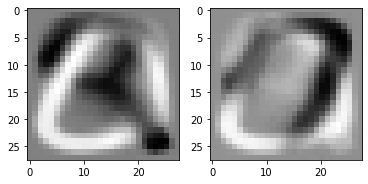

In [ ]:
ImportX = pd.read_csv("x_train.csv", header=None)
ImportT = pd.read_csv("t_train.csv", header=None)
Import = np.concatenate((ImportX, ImportT), axis=1)
df = pd.DataFrame(Import)
# df = df.sample(frac=1).reset_index(drop=True)

trainx = df.iloc[:,:784].values
traint = df.iloc[:,784].values
pca_x = np.empty((300,784))
trainx_pca = np.empty((300, 2))

# Normalize
for i in range(300):
  for j in range(784):
    trainx[i][j] /= 255

mean = np.mean(trainx, axis=0)
print(mean.shape)
for i in range(300):
  for j in range(784):
    pca_x[i][j] = float(trainx[i][j]-mean[j])

# Cov_pca_input = np.cov(pca_x, rowvar=0)
Cov_pca_input = np.dot(pca_x.T, pca_x)/(300-1)
w, v = np.linalg.eigh(Cov_pca_input)

d = 2
W = w.argsort()[-d:][::-1]
V = np.empty((d,28,28))
for i in range(d):
  V[i] = v[:,W[i]:(W[i]+1)].reshape(28,28)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(V[0], cmap="gray")
ax2.imshow(V[1], cmap="gray")

Use PCA to preprocess input data

In [ ]:
W = w[::-1]
v2 = np.zeros((784, 784))
for i in range(784):
  v2[i,:] = v[i,:][::-1]
V = v2[:,0:d].reshape(784,d)

for i in range(300):
  for j in range(784):
    trainx[i][j] = trainx[i][j] - mean[j]

for i in range(300):
  trainx_pca[i] = trainx[i].dot(V)
  
# for i in range(3):
#   plt.scatter(trainx_pca[100*i:100*i+100,0], trainx_pca[100*i:100*i+100,1], alpha=0.8)

SVM with linear and polynomial kernel

48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


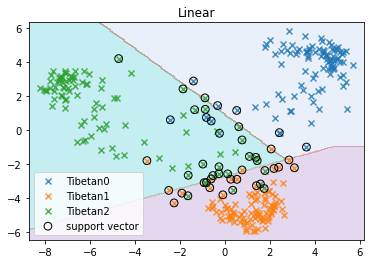

85


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


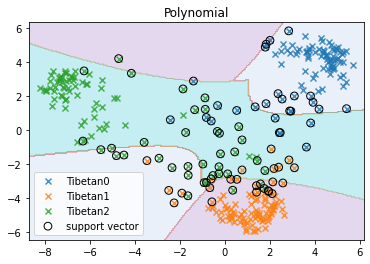

In [ ]:
def Cal_w_b(an, tn, X):
  w = (an*tn).dot(X)
  b = 0
  index_S = np.nonzero(an)[0]
  index_M = np.where((an > 0) & (an < 1))[0]
  for i in index_M:
    sum = 0
    for j in index_S:
      linearkernel = np.dot(X[i], X[j].T)
      sum += an[j] * tn[j]*linearkernel
    b += (tn[i] - sum)
  b /= len(index_M)

  return w, b

def Poly_Phi(X):
  X1 = X[:,0]**2
  X2 = np.sqrt(2)*X[:,0]*X[:,1]
  X3 = X[:,1]**2
  XX = np.zeros((200,3))
  XX[:, 0] = X1
  XX[:, 1] = X2
  XX[:, 2] = X3
  return XX

def Poly_Grid_Phi(X):
  X1 = X[:,0]**2
  X2 = np.sqrt(2)*X[:,0]*X[:,1]
  X3 = X[:,1]**2
  XX = np.zeros((40000,3))
  XX[:, 0] = X1
  XX[:, 1] = X2
  XX[:, 2] = X3
  return XX

def Predict(GridInput, w_01, w_02, w_12, b_01, b_02, b_12):
  p = np.zeros(len(GridInput))
  Label = [0, 1, 2]
  for i in range(len(GridInput)):
    vote = np.zeros(3)

    y = w_01.dot(GridInput[i].T) + b_01
    if y > 0: vote[0] += 1
    else: vote[1] += 1

    y = w_02.dot(GridInput[i].T) + b_02
    if y > 0: vote[0] += 1
    else: vote[2] += 1

    y = w_12.dot(GridInput[i].T) + b_12
    if y > 0: vote[1] += 1
    else: vote[2] += 1

    p[i] = Label[np.argmax(vote)]
  return p

def plot(trainx_pca, x_grid, y_grid, prediction, x_min, y_min, x_max, y_max, SV_index, title):
  plt.contourf(x_grid, y_grid, prediction, cmap='tab20', alpha=0.25)
  for i in range(3):
    plt.scatter(trainx_pca[100*i:100*i+100,0], trainx_pca[100*i:100*i+100,1], marker='x', alpha=0.8, label="Tibetan%d" %i)
  plt.scatter(trainx_pca[SV_index, 0], trainx_pca[SV_index, 1], c='', s=60, marker='o', edgecolors='black', label='support vector')
  plt.xlim((x_min, x_max))
  plt.ylim((y_min, y_max))
  plt.legend()
  plt.title("%s" % title)
  plt.show()

def Linear_SVM():
  clf = SVC(kernel='linear', decision_function_shape='ovo')
  clf.fit(trainx_pca, traint)
  DualCoef = np.abs(clf.dual_coef_)   # alpha
  SV_index = clf.support_         # support vector index
  print(len(SV_index))

  # Multiplier an
  an = np.zeros([len(trainx_pca), 2])
  an[SV_index] = DualCoef.T
  an_01 = an[:200, 0]
  an_02 = np.concatenate((an[:100, 1], an[200:, 0]))
  an_12 = an[100:, 1]

  # Target tN={1, -1}
  tn = np.concatenate((np.ones(100), np.full([100], -1)))

  # train_x
  x_01 = trainx_pca[:200]
  x_02 = np.concatenate((trainx_pca[:100], trainx_pca[200:]))
  x_12 = trainx_pca[100:]

  # weight and bias
  w_01, b_01 = Cal_w_b(an_01, tn, x_01)
  w_02, b_02 = Cal_w_b(an_02, tn, x_02)
  w_12, b_12 = Cal_w_b(an_12, tn, x_12)

  # meshgrid for contourf
  x_min, x_max = trainx_pca[:,0].min()-0.5, trainx_pca[:,0].max()+0.5
  y_min, y_max = trainx_pca[:,1].min()-0.5, trainx_pca[:,1].max()+0.5
  # xx = np.arange(x_min, x_max, 0.01)
  # yy = np.arange(y_min, y_max, 0.01)
  xx = np.linspace(x_min, x_max, 200)
  yy = np.linspace(y_min, y_max, 200)
  x_grid, y_grid = np.meshgrid(xx, yy)

  GridInput = np.c_[x_grid.ravel(), y_grid.ravel()]
  # GridInput = np.column_stack((x_grid.flatten(), y_grid.flatten()))
  prediction = Predict(GridInput, w_01, w_02, w_12, b_01, b_02, b_12)
  prediction = prediction.reshape(x_grid.shape)
  plot(trainx_pca, x_grid, y_grid, prediction, x_min, y_min, x_max, y_max, SV_index, "Linear")


def Poly_SVM():
  clf = SVC(kernel='poly', degree=2, gamma=1, decision_function_shape='ovo')
  clf.fit(trainx_pca, traint)
  DualCoef = np.abs(clf.dual_coef_)   # alpha
  SV_index = clf.support_         # support vector index
  print(len(SV_index))

  # Multiplier an
  an = np.zeros([len(trainx_pca), 2])
  an[SV_index] = DualCoef.T
  an_01 = an[:200, 0]
  an_02 = np.concatenate((an[:100, 1], an[200:, 0]))
  an_12 = an[100:, 1]

  # Target tN={1, -1}
  tn = np.concatenate((np.ones(100), np.full([100], -1)))

  # train_x
  x_01 = trainx_pca[:200]
  x_02 = np.concatenate((trainx_pca[:100], trainx_pca[200:]))
  x_12 = trainx_pca[100:]
  x_01 = Poly_Phi(x_01)
  x_02 = Poly_Phi(x_02)
  x_12 = Poly_Phi(x_12)

  # weight and bias
  w_01, b_01 = Cal_w_b(an_01, tn, x_01)
  w_02, b_02 = Cal_w_b(an_02, tn, x_02)
  w_12, b_12 = Cal_w_b(an_12, tn, x_12)

  # meshgrid for contourf
  x_min, x_max = trainx_pca[:,0].min()-0.5, trainx_pca[:,0].max()+0.5
  y_min, y_max = trainx_pca[:,1].min()-0.5, trainx_pca[:,1].max()+0.5
  xx = np.linspace(x_min, x_max, 200)
  yy = np.linspace(y_min, y_max, 200)
  x_grid, y_grid = np.meshgrid(xx, yy)

  GridInput = np.c_[x_grid.ravel(), y_grid.ravel()]
  GridInput = Poly_Grid_Phi(GridInput)
  prediction = Predict(GridInput, w_01, w_02, w_12, b_01, b_02, b_12)
  prediction = prediction.reshape(x_grid.shape)
  plot(trainx_pca, x_grid, y_grid, prediction, x_min, y_min, x_max, y_max, SV_index, "Polynomial")


Linear_SVM()
Poly_SVM()


# 3 Gaussian Mixture Model

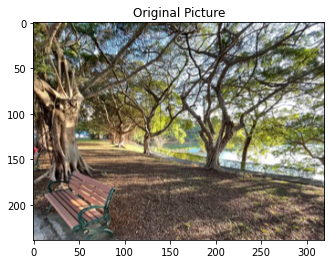

In [37]:
import matplotlib.image as mpimg
Img = mpimg.imread('/content/imghw3.jpg')/255
plt.title("Original Picture")
plt.imshow(Img)

K-means: The grouping is done minimizing the sum of the distances between each object and the group or cluster centroid. The distance usually used is the quadratic or euclidean distance.

1.   Initialization: once the number of groups, k has been chosen, k centroids are established in the data space, for instance, choosing them randomly.
2.   Assignment of objects to the centroids: each object of the data is assigned to its nearest centroid.
3.   Centroids update: The position of the centroid of each group is updated taking as the new centroid the average position of the objects belonging to said group.

Repeat steps 2 and 3 until the centroids do not move, or move below a threshold distance in each step.




In [38]:
from numpy.random import multivariate_normal

class KMeans:
  def __init__(self, K, Img):
    self.K = K
    self.K_Means_iter = 5
    self.GMM_iter = 100
    self.Img = Img
    self.height = Img.shape[0]
    self.width = Img.shape[1]
    self.channel = Img.shape[2]
    self.mu = np.random.rand(self.K, 3)
    self.rnk = np.empty((self.height, self.width))

  def K_Means(self):
    for i in range(self.K_Means_iter):
      Cal_mu_count = np.zeros(self.K)
      Cal_mu = np.zeros((self.K, 3))
      for h in range(self.height):
        for w in range(self.width):
          dist = np.zeros(self.K)
          for m in range(self.K):
            dist[m] = np.sum((Img[h][w] - self.mu[m])**2)
          self.rnk[h][w] = np.argmin(dist)
          Cal_mu_count[np.argmin(dist)] += 1
          Cal_mu[np.argmin(dist)] += Img[h][w]
      for k in range(self.K):
        self.mu[k] = Cal_mu[k] / (Cal_mu_count[k]+1)

  def K_Means_Plot(self, K):
    self.KMeansPlot = np.empty((self.Img.shape))
    for h in range(self.height):
      for w in range(self.width):
        self.KMeansPlot[h][w] = self.mu[int(self.rnk[h][w])]

    fig, ax = plt.subplots()
    ax.set_title("K = %d" % K)
    ax.imshow(self.KMeansPlot)

In [39]:
import math

def pdf_multivariate_gaussian(x, mu, cov):
  part1 = 1 / np.sqrt(((2*np.pi)**(3)) * (np.linalg.det(cov)))
  part2 = (-1/2) * ((x-mu).T.dot(np.linalg.pinv(cov))).dot((x-mu))
  distri = float(part1 * np.exp(part2))
  return distri

class GMM:
  def __init__(self, K, Img):
    self.K = K
    self.Img = Img
    self.height = Img.shape[0]
    self.width = Img.shape[1]
    self.channel = Img.shape[2]
    self.pi = np.ones(self.K)/self.K    # (1, K) = Nk/N
    self.GMM_mu = K_Means.mu        # (K, 3)
    self.r_znk = np.empty((self.height, self.width, self.K))
    self.cov = np.empty((self.K,3,3))        # (K, 3, 3)
    self.N_k = np.zeros(self.K)
    self.ML = 0
    self.LogLikelihood = []
    for i in range(self.K):
      self.cov[i] = np.identity(3)
  
  def MaximumLikelihood(self):
    self.ML = 0
    for h in range(self.height):
      for w in range(self.width):
        MLsum = 0
        for k in range(self.K):
          MLsum += self.pi[k] * pdf_multivariate_gaussian(Img[h][w], self.GMM_mu[k], self.cov[k])
        self.ML += np.log(MLsum)
    return self.ML

  def E_step(self):
    """ Update r_znk """
    for h in range(self.height):
      for w in range(self.width):
        RR = 0
        for k in range(self.K):
          self.r_znk[h][w][k] = self.pi[k] * pdf_multivariate_gaussian(Img[h][w], self.GMM_mu[k], self.cov[k])
          RR += self.r_znk[h][w][k]
        self.r_znk[h][w] /= RR  

  def M_step(self):
    """ Update N_k """
    self.N_k = np.zeros(self.K)
    for h in range(self.height):
      for w in range(self.width):
        for k in range(self.K):
          self.N_k[k] += self.r_znk[h][w][k]

    """ Update Pi """
    self.pi = self.N_k / (self.height * self.width)
    
    """ Update GMM_mu """
    for k in range(self.K):
      for h in range(self.height):
        for w in range(self.width):
          self.GMM_mu[k] += self.r_znk[h][w][k] * Img[h][w]
      self.GMM_mu[k] /= self.N_k[k]

    """ Update cov """
    for k in range(self.K):
      for h in range(self.height):
        for w in range(self.width):
          self.cov[k] += self.r_znk[h][w][k] * (Img[h][w] - self.GMM_mu[k]).reshape(-1,1).dot((Img[h][w] - self.GMM_mu[k]).reshape(-1,1).T)
      self.cov[k] /= self.N_k[k]

    """ Update Log likelihood """
    self.LogLikelihood.append(self.MaximumLikelihood())
    # print(self.MaximumLikelihood())

  def GMMPlot(self):
    self.FinalColor = np.zeros(self.Img.shape)
    for h in range(self.height):
      for w in range(self.width):
        for k in range(self.K):
          self.FinalColor[h][w] += self.GMM_mu[k] * self.r_znk[h][w][k]
    
    fig, ax = plt.subplots()
    ax.set_title("K = %d" % self.K)
    ax.imshow(self.FinalColor)

  def PlotLogLikelihood(self):
    plt.title("Log Likelihood K = %d" % self.K)
    plt.plot([x for x in range(100)], self.LogLikelihood)
    plt.show()


[[0.79418888 0.80441905 0.76190206]
 [0.56190295 0.53794986 0.45205769]
 [0.31028028 0.28146002 0.22378651]]
[[0.44481958 0.41507977 0.33737781]
 [0.17103919 0.14547333 0.0972433 ]
 [0.2946032  0.2648254  0.21386959]
 [0.61081804 0.59228336 0.50363957]
 [0.80472988 0.81652327 0.77968532]]
[[0.31636048 0.2868321  0.23380414]
 [0.1976365  0.17088576 0.12332478]
 [0.63283128 0.67079816 0.67362457]
 [0.85029921 0.86305633 0.83825156]
 [0.55325645 0.52796251 0.46062734]
 [0.7439324  0.68906341 0.48065354]
 [0.45104921 0.4194163  0.33275341]]
[[0.35293557 0.31578711 0.16185154]
 [0.45955725 0.41582827 0.30592762]
 [0.34291917 0.32034509 0.28465164]
 [0.63642139 0.65548419 0.63106164]
 [0.2651381  0.23479321 0.19458421]
 [0.18211827 0.15728115 0.10642612]
 [0.64787297 0.58994298 0.4152383 ]
 [0.09000339 0.05872979 0.02799781]
 [0.83852154 0.84647768 0.80585929]
 [0.4855013  0.48064503 0.45243377]]


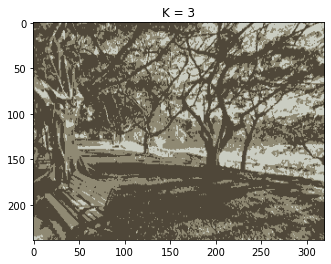

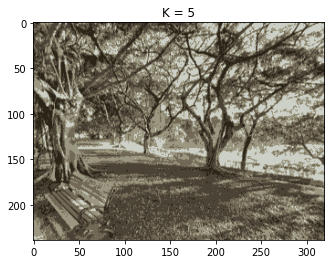

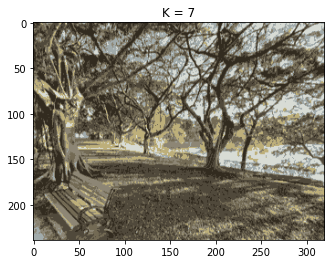

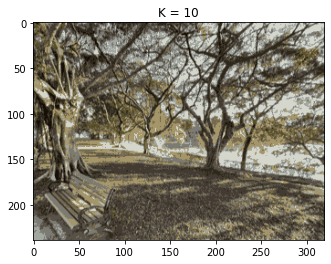

In [40]:
K_List = [3, 5, 7, 10]
# K_List = [10]
for K in K_List:
  K_Means = KMeans(K=K, Img=Img)
  K_Means.K_Means()
  K_Means.K_Means_Plot(K)
  print(K_Means.mu)

備註：因GMM跑的時間太久，因此GMM的部分每一個K分開跑，所有結果請參照報告。

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
When K = 10
Covariance: 
 [[[0.01933118 0.01840891 0.01713828]
  [0.01840891 0.01789215 0.01709932]
  [0.01713

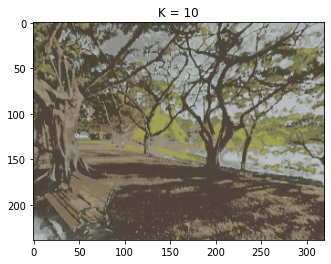

In [ ]:
for K in K_List:
  GMM_ = GMM(K=K, Img=Img)
  for i in range(100):
    print("iter: %d" %i)
    GMM_.E_step()
    GMM_.M_step()
  GMM_.GMMPlot()
  print("When K = %d" % GMM_.K)
  print("Covariance: \n", GMM_.cov)
  print("mu: \n", GMM_.GMM_mu)
  print("Pi: \n", GMM_.pi)

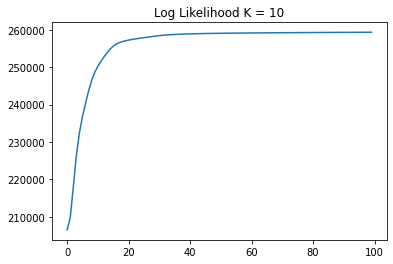

In [ ]:
GMM_.PlotLogLikelihood()